In [1]:
from tortreinador import train
import pandas as pd
import os
import numpy as np
from tortreinador.utils.plot import plot_line_2
from tortreinador.utils.preprocessing import load_data
from tortreinador.train import TorchTrainer
from tortreinador.models.MDN import mdn, Mixture, NLLLoss
from tortreinador.utils.View import init_weights, split_weights
import joblib
import torch

In [5]:
input_parameters = [
    'Mass',
    'Radius',
    'Fe_(Mg+Si)',
    'k2',
]


output_parameters = [
    'WRF',
    'MRF',
    'CRF',
    'CMF',
    'PRS_CMB',
    'TEP_CMB',
]

In [3]:
trainer = train.TorchTrainer(epoch=200)

Batch size: 512, Epoch:200, is GPU: True


In [4]:
model = mdn(len(input_parameters), len(output_parameters), 20, 512)
init_weights(model)
criterion = NLLLoss()
pdf = Mixture()
optim = torch.optim.Adam(split_weights(model), lr=0.0001)


In [5]:
file_path = 'D:\\Resource\\MRCK_2\\'
nowater_data_frames = []

file_nowater = os.listdir(file_path + 'nowater')
for f in file_nowater:
    tmp = pd.read_table(file_path + '\\' + 'nowater\\' + f, delimiter="\s+", header=None)
    nowater_data_frames.append(tmp)

df_nowater = pd.concat(nowater_data_frames)


file_water = os.listdir(file_path + 'water')
water_data_frames = []
for f in file_water:
    tmp = pd.read_table(file_path + '\\' + 'water\\' + f, delimiter="\s+", header=None)
    water_data_frames.append(tmp)

df_water = pd.concat(water_data_frames)


# combine merged nowater and water data
df_all = pd.concat([df_nowater, df_water])

# rename columns
df_all.columns = ['Mass', 'Radius', 'WMF',
                  'CMF', 'WRF', 'CRF', 'PRS_WMB',
                  'TEP_WMB', 'PRS_CMB', 'TEP_CMB', 'PRS_CEN', 'TEP_CEN',
                  'k2', 'FeMg_mantle', 'SiMg_mantle', 'FeO_mantle']

# reset index
df_all = df_all.reset_index(drop=True)

df_all = df_all.astype(float)

CaMg = 0.06
AlMg = 0.08
wt_frac_S_core = 0.0695     # by mass

mFe = 55.845
mMg = 24.306
mSi = 28.0867
mO = 15.9994
mS = 32.0650
mCa = 40.078
mAl = 26.981

# you can check the FeO_mantle results from the mantle molar ratios FeMg, SiMg, CaMg, AlMg
# The results should be same as the column FeO_mantle
reduced_mantle_mass = df_all['FeMg_mantle'] * (mFe+mO) + df_all['SiMg_mantle'] * (mSi+2.0*mO) + CaMg * (mCa+mO) + AlMg * (mAl+1.5*mO) + (mMg+mO)
FeO_mantle_cal = df_all['FeMg_mantle'] * (mFe+mO) / reduced_mantle_mass

# number of Fe atoms in the core
nFe_core = df_all['CMF'] * (1.0 - wt_frac_S_core) / mFe

# number of Fe atoms in the mantle
nFe_mantle = (1.0 - df_all['CMF'] - df_all['WMF']) * df_all['FeO_mantle'] / (mFe + mO)

# number of Mg atoms in the mantle
nMg_mantle = nFe_mantle / df_all['FeMg_mantle']

# bulk FeMg
FeMg = (nFe_core + nFe_mantle) / nMg_mantle
df_all['FeMg'] = FeMg

# bulk SiMg: there is no Si & Mg in the core
df_all['SiMg'] = df_all['SiMg_mantle']

df_all = df_all[df_all['FeMg']<=40]

df_all["Fe_(Mg+Si)"] = df_all["FeMg"]/(df_all["SiMg"] + 1)

df_all["MRF"] = 1 - df_all["WRF"] - df_all["CRF"]

In [6]:
t_loader, v_loader, test_x, test_y, s_x, s_y = load_data(data=df_all, input_parameters=input_parameters, output_parameters=output_parameters,
                           if_normal=True, if_shuffle=True, batch_size=512)

In [8]:
t_l, v_l, val_r2, train_r2, mse = trainer.fit_for_MDN(t_loader, v_loader, criterion, model=model, mixture=pdf, model_save_path='D:\\Resource\\MDN\\rockyExoplanetV2\\', optim=optim, best_r2=0.8, warmup_epoch=5)


module.root_layer.0.weight : torch.Size([512, 4])
module.root_layer.0.bias : torch.Size([512])
module.root_layer.2.weight : torch.Size([512, 512])
module.root_layer.2.bias : torch.Size([512])
module.root_layer.4.weight : torch.Size([512, 512])
module.root_layer.4.bias : torch.Size([512])
module.pi.0.weight : torch.Size([512, 512])
module.pi.0.bias : torch.Size([512])
module.pi.2.weight : torch.Size([20, 512])
module.pi.2.bias : torch.Size([20])
module.mu.0.weight : torch.Size([512, 512])
module.mu.0.bias : torch.Size([512])
module.mu.2.weight : torch.Size([120, 512])
module.mu.2.bias : torch.Size([120])
module.sigma.0.weight : torch.Size([512, 512])
module.sigma.0.bias : torch.Size([512])
module.sigma.2.weight : torch.Size([120, 512])
module.sigma.2.bias : torch.Size([120])


  0%|          | 0/6808 [00:00<?, ?batch/s]E:\anaconda\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Epoch 2 Validating: 100%|██████████| 851/851 [00:09<00:00, 85.90batch/s, loss=-21.3558, loss_avg=-21.2948, mse=0.0090, r2=0.8177] 


Save Best model: R2:0.8177, Loss Avg:-21.2948


Epoch 3 Validating: 100%|██████████| 851/851 [00:09<00:00, 86.40batch/s, loss=-22.7249, loss_avg=-22.5239, mse=0.0061, r2=0.8700] 


Save Best model: R2:0.8700, Loss Avg:-22.5239


Epoch 4 Validating: 100%|██████████| 851/851 [00:09<00:00, 87.83batch/s, loss=-24.1824, loss_avg=-23.8351, mse=0.0059, r2=0.8843] 


Save Best model: R2:0.8843, Loss Avg:-23.8351


Epoch 7 Validating: 100%|██████████| 851/851 [00:09<00:00, 90.28batch/s, loss=-26.0221, loss_avg=-25.8940, mse=0.0021, r2=0.9568] 


Save Best model: R2:0.9568, Loss Avg:-25.8940


Epoch 8 Validating: 100%|██████████| 851/851 [00:09<00:00, 88.11batch/s, loss=-26.9058, loss_avg=-26.6376, mse=0.0010, r2=0.9751] 


Save Best model: R2:0.9751, Loss Avg:-26.6376


Epoch 9 Validating: 100%|██████████| 851/851 [00:09<00:00, 88.18batch/s, loss=-27.9398, loss_avg=-27.9444, mse=0.0008, r2=0.9846] 


Save Best model: R2:0.9846, Loss Avg:-27.9444


Epoch 10 Validating: 100%|██████████| 851/851 [00:09<00:00, 89.33batch/s, loss=-28.6171, loss_avg=-28.6328, mse=0.0007, r2=0.9873] 


Save Best model: R2:0.9873, Loss Avg:-28.6328


Epoch 11 Validating: 100%|██████████| 851/851 [00:09<00:00, 89.47batch/s, loss=-29.1915, loss_avg=-29.1434, mse=0.0005, r2=0.9896] 


Save Best model: R2:0.9896, Loss Avg:-29.1434


Epoch 12 Validating: 100%|██████████| 851/851 [00:09<00:00, 89.36batch/s, loss=-29.1268, loss_avg=-29.0449, mse=0.0005, r2=0.9903] 


Save Best model: R2:0.9903, Loss Avg:-29.0449


Epoch 13 Validating: 100%|██████████| 851/851 [00:09<00:00, 88.15batch/s, loss=-29.9752, loss_avg=-29.9220, mse=0.0004, r2=0.9917] 


Save Best model: R2:0.9917, Loss Avg:-29.9220


Epoch 14 Validating: 100%|██████████| 851/851 [00:09<00:00, 88.08batch/s, loss=-29.9156, loss_avg=-29.8313, mse=0.0004, r2=0.9921] 


Save Best model: R2:0.9921, Loss Avg:-29.8313


Epoch 15 Validating: 100%|██████████| 851/851 [00:09<00:00, 89.51batch/s, loss=-30.1603, loss_avg=-30.1207, mse=0.0003, r2=0.9930] 


Save Best model: R2:0.9930, Loss Avg:-30.1207


Epoch 16 Validating: 100%|██████████| 851/851 [00:09<00:00, 87.32batch/s, loss=-30.6381, loss_avg=-30.6273, mse=0.0004, r2=0.9935] 


Save Best model: R2:0.9935, Loss Avg:-30.6273


Epoch 18 Validating: 100%|██████████| 851/851 [00:09<00:00, 89.31batch/s, loss=-30.6304, loss_avg=-30.5871, mse=0.0003, r2=0.9941] 


Save Best model: R2:0.9941, Loss Avg:-30.5871


Epoch 21 Validating: 100%|██████████| 851/851 [00:09<00:00, 87.58batch/s, loss=-31.3945, loss_avg=-31.4400, mse=0.0003, r2=0.9941] 


Save Best model: R2:0.9941, Loss Avg:-31.4400


Epoch 22 Validating: 100%|██████████| 851/851 [00:09<00:00, 88.64batch/s, loss=-31.8135, loss_avg=-31.7377, mse=0.0003, r2=0.9946] 


Save Best model: R2:0.9946, Loss Avg:-31.7377


Epoch 24 Validating: 100%|██████████| 851/851 [00:09<00:00, 88.31batch/s, loss=-32.0742, loss_avg=-31.9830, mse=0.0002, r2=0.9949] 


Save Best model: R2:0.9949, Loss Avg:-31.9830


Epoch 33 Validating: 100%|██████████| 851/851 [00:09<00:00, 89.76batch/s, loss=-32.3310, loss_avg=-32.3014, mse=0.0003, r2=0.9950] 


Save Best model: R2:0.9950, Loss Avg:-32.3014


Epoch 36 Validating: 100%|██████████| 851/851 [00:09<00:00, 87.41batch/s, loss=-32.0258, loss_avg=-32.0576, mse=0.0002, r2=0.9951] 


Save Best model: R2:0.9951, Loss Avg:-32.0576


Epoch 40 Validating: 100%|██████████| 851/851 [00:09<00:00, 90.42batch/s, loss=-32.7354, loss_avg=-32.6678, mse=0.0003, r2=0.9952] 


Save Best model: R2:0.9952, Loss Avg:-32.6678


Epoch 42 Validating: 100%|██████████| 851/851 [00:09<00:00, 89.02batch/s, loss=-32.7140, loss_avg=-32.6536, mse=0.0002, r2=0.9953] 


Save Best model: R2:0.9953, Loss Avg:-32.6536


Epoch 45 Validating: 100%|██████████| 851/851 [00:09<00:00, 88.45batch/s, loss=-32.7969, loss_avg=-32.6617, mse=0.0002, r2=0.9954] 


Save Best model: R2:0.9954, Loss Avg:-32.6617


Epoch 48 Validating: 100%|██████████| 851/851 [00:09<00:00, 89.13batch/s, loss=-33.3241, loss_avg=-33.2604, mse=0.0002, r2=0.9954] 


Save Best model: R2:0.9954, Loss Avg:-33.2604


Epoch 51 Validating: 100%|██████████| 851/851 [00:09<00:00, 88.58batch/s, loss=-32.9889, loss_avg=-32.9487, mse=0.0002, r2=0.9955] 


Save Best model: R2:0.9955, Loss Avg:-32.9487


Epoch 56 Validating: 100%|██████████| 851/851 [00:09<00:00, 88.53batch/s, loss=-33.3927, loss_avg=-33.4257, mse=0.0002, r2=0.9956] 


Save Best model: R2:0.9956, Loss Avg:-33.4257


Epoch 57 Validating: 100%|██████████| 851/851 [00:09<00:00, 90.44batch/s, loss=-33.8955, loss_avg=-33.9265, mse=0.0002, r2=0.9958] 


Save Best model: R2:0.9958, Loss Avg:-33.9265


Epoch 59 Validating: 100%|██████████| 851/851 [00:09<00:00, 89.08batch/s, loss=-33.6948, loss_avg=-33.5104, mse=0.0002, r2=0.9958] 


Save Best model: R2:0.9958, Loss Avg:-33.5104


Epoch 60 Validating: 100%|██████████| 851/851 [00:09<00:00, 87.80batch/s, loss=-34.1545, loss_avg=-34.1593, mse=0.0002, r2=0.9959] 


Save Best model: R2:0.9959, Loss Avg:-34.1593


Epoch 61 Validating: 100%|██████████| 851/851 [00:09<00:00, 88.53batch/s, loss=-34.1793, loss_avg=-34.1650, mse=0.0002, r2=0.9959] 


Save Best model: R2:0.9959, Loss Avg:-34.1650


Epoch 74 Validating: 100%|██████████| 851/851 [00:09<00:00, 89.37batch/s, loss=-34.1956, loss_avg=-34.0965, mse=0.0002, r2=0.9959] 


Save Best model: R2:0.9959, Loss Avg:-34.0965


Epoch 82 Validating: 100%|██████████| 851/851 [00:09<00:00, 89.33batch/s, loss=-34.6920, loss_avg=-34.6582, mse=0.0001, r2=0.9961] 


Save Best model: R2:0.9961, Loss Avg:-34.6582


Epoch 88 Validating: 100%|██████████| 851/851 [00:09<00:00, 89.32batch/s, loss=-34.2347, loss_avg=-34.1292, mse=0.0001, r2=0.9961] 


Save Best model: R2:0.9961, Loss Avg:-34.1292


Epoch 97 Validating: 100%|██████████| 851/851 [00:09<00:00, 90.36batch/s, loss=-34.9317, loss_avg=-34.9305, mse=0.0002, r2=0.9962] 


Save Best model: R2:0.9962, Loss Avg:-34.9305


Epoch 99 Validating: 100%|██████████| 851/851 [00:09<00:00, 90.50batch/s, loss=-34.5171, loss_avg=-34.5637, mse=0.0002, r2=0.9962] 


Save Best model: R2:0.9962, Loss Avg:-34.5637


Epoch 105 Validating: 100%|██████████| 851/851 [00:09<00:00, 89.84batch/s, loss=-34.7432, loss_avg=-34.8474, mse=0.0002, r2=0.9962] 


Save Best model: R2:0.9962, Loss Avg:-34.8474


Epoch 109 Validating: 100%|██████████| 851/851 [00:09<00:00, 90.90batch/s, loss=-35.1584, loss_avg=-35.2166, mse=0.0002, r2=0.9963] 


Save Best model: R2:0.9963, Loss Avg:-35.2166


Epoch 138 Validating: 100%|██████████| 851/851 [00:09<00:00, 89.78batch/s, loss=-35.9973, loss_avg=-35.9330, mse=0.0002, r2=0.9963] 


Save Best model: R2:0.9963, Loss Avg:-35.9330


Epoch 145 Validating: 100%|██████████| 851/851 [00:09<00:00, 91.90batch/s, loss=-35.9334, loss_avg=-35.8424, mse=0.0002, r2=0.9963] 


Save Best model: R2:0.9963, Loss Avg:-35.8424


Epoch 154 Validating: 100%|██████████| 851/851 [00:09<00:00, 92.06batch/s, loss=-35.5643, loss_avg=-35.5767, mse=0.0002, r2=0.9963] 


Save Best model: R2:0.9963, Loss Avg:-35.5767


Epoch 161 Validating: 100%|██████████| 851/851 [00:09<00:00, 92.49batch/s, loss=-36.0612, loss_avg=-35.9640, mse=0.0001, r2=0.9964] 


Save Best model: R2:0.9964, Loss Avg:-35.9640


Epoch 180 Validating: 100%|██████████| 851/851 [00:09<00:00, 91.67batch/s, loss=-35.7572, loss_avg=-35.7729, mse=0.0002, r2=0.9964] 


Save Best model: R2:0.9964, Loss Avg:-35.7729


Epoch 181 Validating: 100%|██████████| 851/851 [00:09<00:00, 90.12batch/s, loss=-36.9144, loss_avg=-36.8286, mse=0.0001, r2=0.9965] 


Save Best model: R2:0.9965, Loss Avg:-36.8286


Epoch 185 Validating: 100%|██████████| 851/851 [00:09<00:00, 91.98batch/s, loss=-37.0043, loss_avg=-36.9389, mse=0.0001, r2=0.9965] 


Save Best model: R2:0.9965, Loss Avg:-36.9389


Epoch 200 Validating: 100%|██████████| 851/851 [00:09<00:00, 92.44batch/s, loss=-35.1154, loss_avg=-35.0824, mse=0.0002, r2=0.9962] 


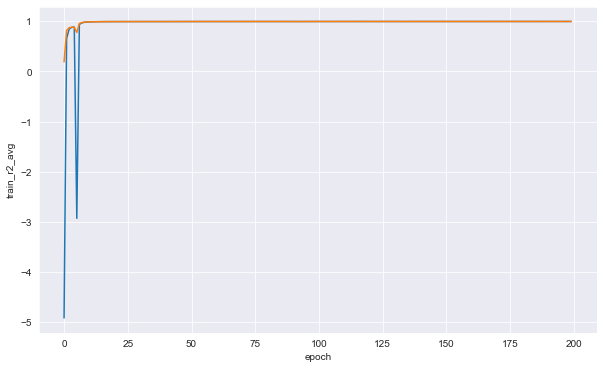

In [9]:
result_pd = pd.DataFrame()
result_pd['epoch'] = range(200)
result_pd['train_r2_avg'] = train_r2
result_pd['val_r2_avg'] = val_r2

plot_line_2(y_1='train_r2_avg', y_2='val_r2_avg', df=result_pd, fig_size=(10, 6), output_path="D:\\PythonProject\\RebuildProject\\Rock\\imgs\\MRCk2_MDN20231129_TrainValR2.png", dpi=300)

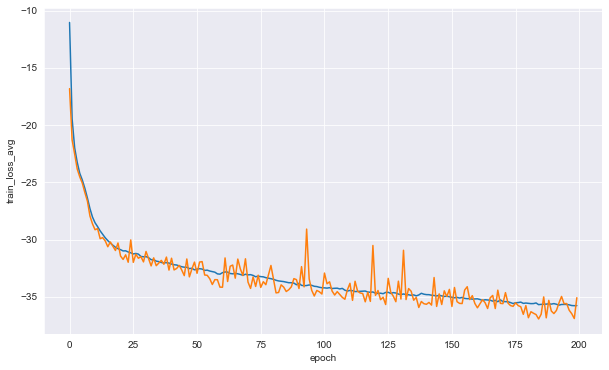

In [10]:
result_pd = pd.DataFrame()
result_pd['epoch'] = range(200)
result_pd['train_loss_avg'] = t_l
result_pd['val_loss_avg'] = v_l

plot_line_2(y_1='train_loss_avg', y_2='val_loss_avg', df=result_pd, fig_size=(10, 6), output_path="D:\\PythonProject\\RebuildProject\\Rock\\imgs\\MRCk2_MDN20231129_TrainValLoss.png", dpi=300)

In [16]:
r2_distance = np.abs((np.array(train_r2) - np.array(val_r2)).mean())
loss_distance = np.abs((np.array(t_l) - np.array(v_l)).mean())
loss_dis_df = pd.DataFrame(np.abs(np.array(t_l) - np.array(v_l))).iloc[10:, :]
max_dis_10 = loss_dis_df.sort_values(by=0, ascending=False).iloc[:10, :].sort_index()
dis_mean = max_dis_10.mean()
dis_std = max_dis_10.std()

In [18]:
cov = np.cov(np.array(t_l), np.array(v_l))

In [12]:
test_x_np = test_x.numpy()
test_y_np = test_y.numpy()

In [13]:
np.save('D:\\Resource\\MDN\\TestDataMRCk2\\test_x.npy', test_x_np)
np.save('D:\\Resource\\MDN\\TestDataMRCk2\\test_y.npy', test_y_np)
# np.save('D:\\Resource\\MDN\\TestDataMRCk2\\scaler_x.npy', s_x)
# np.save('D:\\Resource\\MDN\\TestDataMRCk2\\scaler_y.npy', s_y)

In [14]:
joblib.dump(s_x, "D:\\Resource\\MDN\\TestDataMRCk2\\MDN_MRCk2_Xscaler_20231201.save")
joblib.dump(s_y, "D:\\Resource\\MDN\\TestDataMRCk2\\MDN_MRCk2_yscaler_20231201.save")

['D:\\Resource\\MDN\\TestDataMRCk2\\MDN_MRCk2_yscaler_20231201.save']

In [2]:
import torch.nn as nn
from tortreinador.utils.metrics import r2_score

In [3]:
t_x = np.load("D:\\Resource\\MDN\\TestDataMRCk2\\test_x.npy")
t_y = np.load("D:\\Resource\\MDN\\TestDataMRCk2\\test_y.npy")
m_y = joblib.load("D:\\Resource\\MDN\\TestDataMRCk2\\MDN_MRCk2_yscaler_20231201.save")

In [7]:
model = mdn(len(input_parameters), len(output_parameters), 20, 512)
init_weights(model)
model = nn.DataParallel(model)
model.to("cuda")
model.load_state_dict(torch.load("D:\\Resource\\MDN\\rockyExoplanetV2\\best_model.pth"))


<All keys matched successfully>

In [8]:
# Predict
model.eval()
pi, mu, sigma = model(torch.from_numpy(t_x))
mix = Mixture()
criterion = NLLLoss()
mse = nn.MSELoss()
sample = mix(pi, mu, sigma).sample()
print("NLLLoss: {}, MSE: {}, R2: {}".format(criterion(pi, mu, sigma, torch.from_numpy(t_y).to('cuda')),
                                            mse(torch.from_numpy(t_y).to('cuda'), sample),
                                            r2_score(sample, torch.from_numpy(t_y).to('cuda'))))

NLLLoss: -36.934946396735256, MSE: 0.00014880198387144894, R2: 0.99652592268116
